In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
Images_Tumor_path = '/content/drive/My Drive/CSAW_Images/Tumor'
Images_Tumor_Folder = os.listdir(Images_Tumor_path)

Masks_Tumor_path = '/content/drive/My Drive/CSAW_Images/Tumor/Annotations'
Masks_Tumor_Folder = os.listdir(Masks_Tumor_path)

Images_Healthy_path = '/content/drive/My Drive/CSAW_Images/Healthy'
Images_Healthy_Folder = os.listdir(Images_Healthy_path)

Masks_Healthy_path = '/content/drive/My Drive/CSAW_Images/Healthy/Annotations'
Masks_Healthy_Folder = os.listdir(Masks_Healthy_path)

Mounted at /content/drive


In [3]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.6 MB/s eta 0:00:00


# **Imports**

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
import cv2
import tensorflow as tf

Sort files

In [5]:
# Sort the file lists to ensure the correct order
sorted_tumor_images = sorted(Images_Tumor_Folder)
sorted_tumor_masks = sorted(Masks_Tumor_Folder)
sorted_healthy_images = sorted(Images_Healthy_Folder)
sorted_healthy_masks = sorted(Masks_Healthy_Folder)

sorted_tumor_images_path = [os.path.join(Images_Tumor_path, img) for img in sorted_tumor_images]
sorted_tumor_masks_path = [os.path.join(Masks_Tumor_path, mask) for mask in sorted_tumor_masks]
sorted_healthy_images_path = [os.path.join(Images_Healthy_path, img) for img in sorted_healthy_images]
sorted_healthy_masks_path = [os.path.join(Masks_Healthy_path, mask) for mask in sorted_healthy_masks]


Preprocessing functions; Cropping, Resizing and Padding

In [9]:
# Function to crop the image and mask based on the bounding box of the image
def crop_image_based_on_image(image, mask):

    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image

    # Normalize image and threshold it to find the contour area
    gray_image = ((gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image)) * 255).astype(np.uint8)
    _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY)

    # Ensure binary image is of type uint8
    thresh = thresh.astype(np.uint8)

    # Find contours in the image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter small contours by area
    min_contour_area = 1000
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Check if any contours remain after filtering
    if len(filtered_contours) > 0:
        # Find the largest contour by area
        largest_contour = max(filtered_contours, key=cv2.contourArea)

        # Create bounding box around the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the image and mask using the bounding box
        cropped_image = image[y:y+h, x:x+w]
        cropped_mask = mask[y:y+h, x:x+w]

        return cropped_image, cropped_mask
    else:
        return None, None

# Function to resize and pad the image while maintaining aspect ratio
def resize_and_pad(image, target_size=(224, 224)):
    if image.dtype != np.uint8:
      image = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)

    # Get current size (height, width)
    old_size = image.shape[:2]

    # Get the aspect ratio
    ratio = min(target_size[1] / old_size[1], target_size[0] / old_size[0])
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize the image
    resized = cv2.resize(image, (new_size[1], new_size[0]))

    delta_w = int(target_size[1] - new_size[1])
    delta_h = int(target_size[0] - new_size[0])
    top, bottom = int(delta_h // 2), int(delta_h - (delta_h // 2))
    left, right = int(delta_w // 2), int(delta_w - (delta_w // 2))

    # Pad the image
    if len(image.shape) == 2:
        resized_padded_image = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    else:
        resized_padded_image = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return resized_padded_image

# Function to load and preprocess the DICOM image and PNG mask
def load_data(img_paths, mask_paths, target_size=(224, 224)):
    original_images = []
    original_masks = []
    processed_images = []
    processed_masks = []

    for img_path, mask_path in zip(img_paths, mask_paths):
        # Load and preprocess DICOM image
        ds = pydicom.dcmread(img_path)
        img = ds.pixel_array

        # Load and preprocess the PNG mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Store the original image and mask
        original_images.append(img)
        original_masks.append(mask)

        # Crop the image and mask based on the image bounding box
        img, mask = crop_image_based_on_image(img, mask)
        if img is None or mask is None:
            continue

        # Resize and pad the cropped image and mask
        img = resize_and_pad(img, target_size)
        mask = resize_and_pad(mask, target_size)

        # Convert image to 3 channels (RGB)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Convert mask to a single channel image
        mask = np.expand_dims(mask, axis=-1)

        # Store the processed image and mask
        processed_images.append(img)
        processed_masks.append(mask)

    return original_images, original_masks, processed_images, processed_masks

Visualize Preprocessing results

Shape after processing: (224, 224, 3)
Max Pixel value after processing: 248


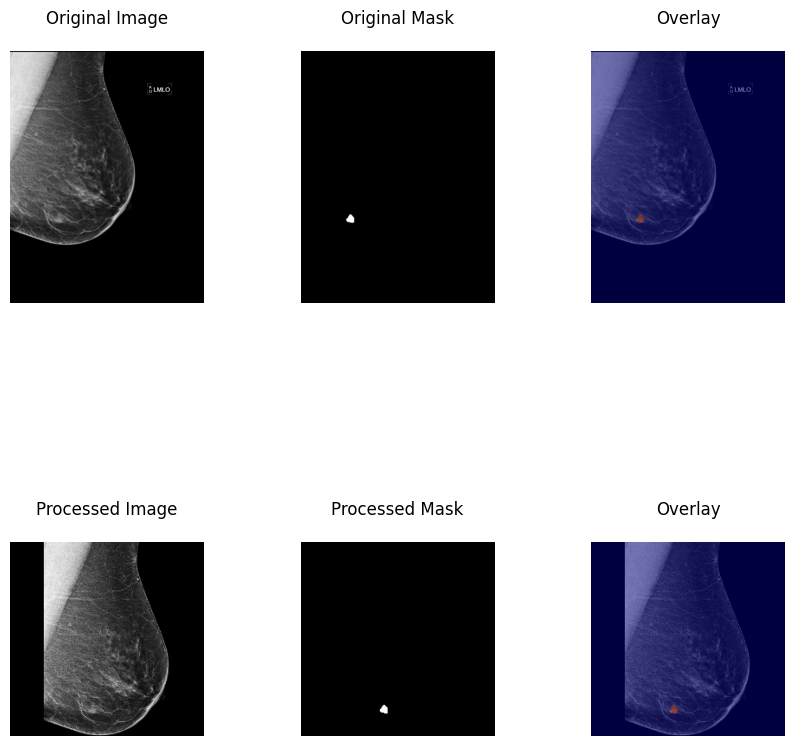

Shape after processing: (224, 224, 3)
Max Pixel value after processing: 247


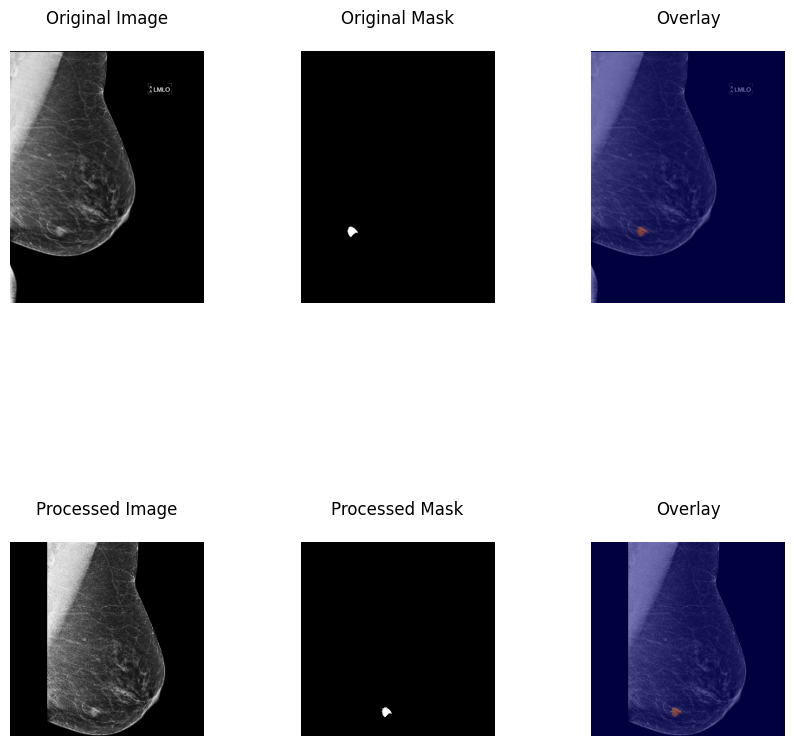

Shape after processing: (224, 224, 3)
Max Pixel value after processing: 254


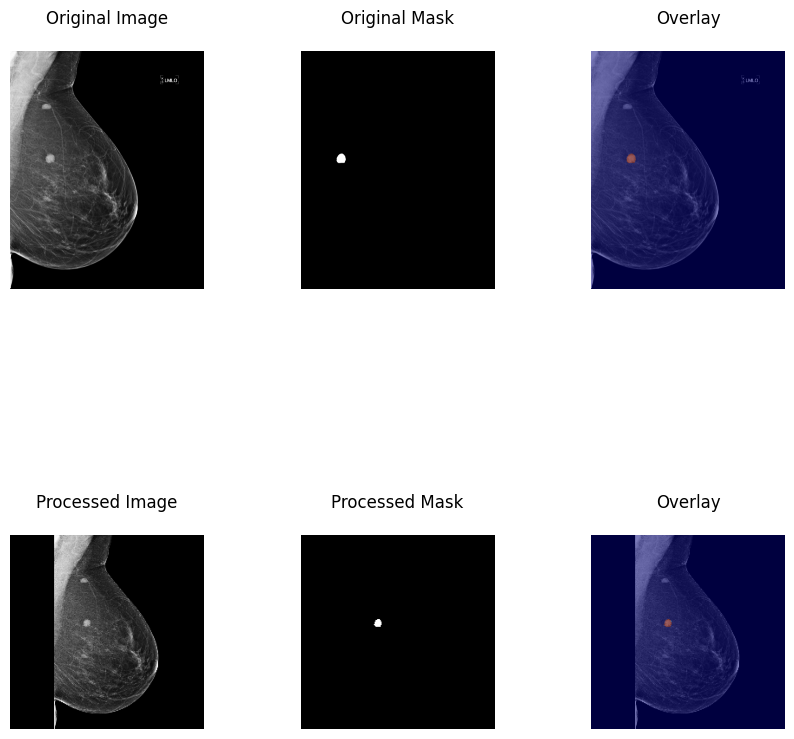

Shape after processing: (224, 224, 3)
Max Pixel value after processing: 252


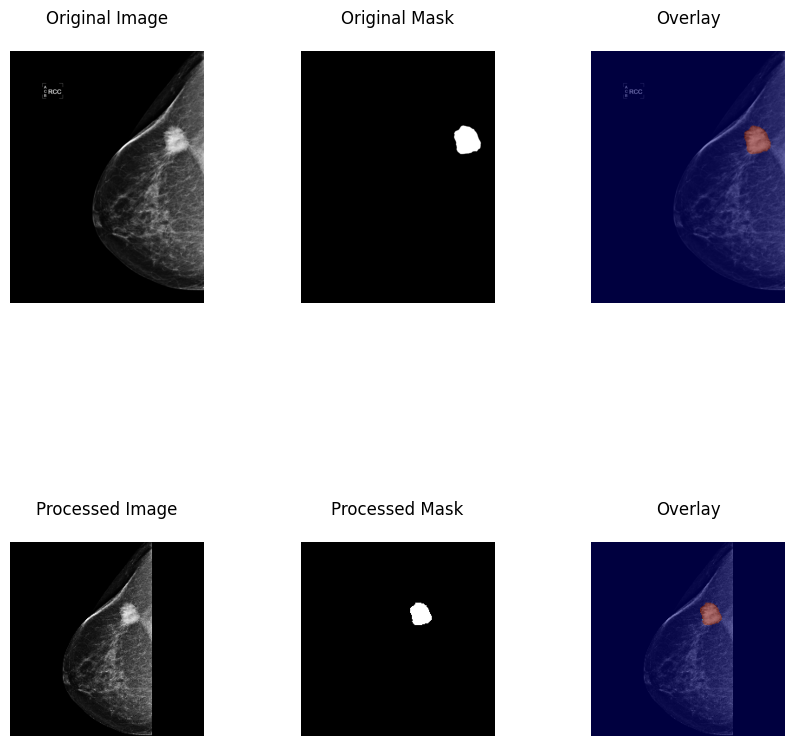

In [12]:
# Select the 5 pairs of images and masks for testing
img_paths = sorted_tumor_images_path[34:38]
mask_paths = sorted_tumor_masks_path[34:38]

# Load and preprocess the images and masks
original_images, original_masks, processed_images, processed_masks = load_data(img_paths, mask_paths, target_size=(224, 224))

# Display images and masks
for i in range(min(5, len(processed_images))):
    plt.figure(figsize=(10, 10))

    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(original_images[i], cmap='gray')
    plt.title('Original Image', pad=20)
    plt.axis('off')

    # Display the original mask
    plt.subplot(2, 3, 2)
    plt.imshow(original_masks[i], cmap='gray')
    plt.title('Original Mask', pad=20)
    plt.axis('off')

    # Display the mask overlay
    plt.subplot(2, 3, 3)
    plt.imshow(original_images[i], cmap='gray')
    plt.imshow(original_masks[i], cmap='jet', alpha=0.5)
    plt.title('Overlay', pad=20)
    plt.axis('off')

    # Display the processed image
    plt.subplot(2, 3, 4)
    plt.imshow(processed_images[i])
    plt.title('Processed Image', pad=20)
    plt.axis('off')
    print(f'Shape after processing: {processed_images[i].shape}')
    print(f'Max Pixel value after processing: {processed_images[i].max()}')

    # Display the processed mask
    plt.subplot(2, 3, 5)
    plt.imshow(processed_masks[i].squeeze(), cmap='gray')
    plt.title('Processed Mask', pad=20)
    plt.axis('off')

    # Display the mask overlay for processed image
    plt.subplot(2, 3, 6)
    plt.imshow(processed_images[i])
    plt.imshow(processed_masks[i].squeeze(), cmap='jet', alpha=0.5)
    plt.title('Overlay', pad=20)
    plt.axis('off')

    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    plt.show()